<a href="https://colab.research.google.com/github/rodrigohaddad/RNSP/blob/main/t1/t1_kmnist_with_encoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install wisardpkg
!git clone https://github.com/rois-codh/kmnist.git
!python /content/kmnist/download_data.py

!git clone https://gist.github.com/1fe5c78be9a5ec2d507e8118e2c99740.git
!mv 1fe5c78be9a5ec2d507e8118e2c99740/*.py ./
!rm -rf ./1fe5c78be9a5ec2d507e8118e2c99740

     |████████████████████████████████| 133kB 25.7MB/s 
     |████████████████████████████████| 194kB 29.6MB/s 
  ERROR: Failed building wheel for wisardpkg
  Running setup.py clean for wisardpkg
Failed to build wisardpkg
    Running setup.py install for wisardpkg ... done
Cloning into 'kmnist'...
remote: Enumerating objects: 211, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 211 (delta 0), reused 0 (delta 0), pack-reused 208
Receiving objects: 100% (211/211), 408.40 KiB | 34.03 MiB/s, done.
Resolving deltas: 100% (117/117), done.
Please select a download option:
1) Kuzushiji-MNIST (10 classes, 28x28, 70k examples)
2) Kuzushiji-49 (49 classes, 28x28, 270k examples)
3) Kuzushiji-Kanji (3832 classes, 64x64, 140k examples)
> 1
Please select a download option:
1) MNIST data format (ubyte.gz)
2) NumPy data format (.npz)
> 2
100% 17954/17954 [00:03<00:00, 5737.35KB/s]
100% 30/30 [00:00<00:00, 198.85KB/s]
100% 3008/3008 [00:01<0

In [50]:
import wisardpkg as wp

import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from skimage.data import page
from skimage.filters import threshold_otsu, threshold_niblack, threshold_sauvola

from encoders import ThermometerEncoder, CircularThermometerEncoder, FloatBinaryEncoder

In [51]:
def load(f):
    return np.load(f)['arr_0']

# Load the data
imgs = {'x_train': load('kmnist-train-imgs.npz'),
        'x_test': load('kmnist-test-imgs.npz')}

labels = {'y_train': [str(i) for i in load('kmnist-train-labels.npz')],
          'y_test': [str(i) for i in load('kmnist-test-labels.npz')]}

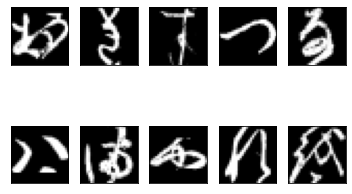

In [52]:
def sample_digit(target, X=imgs['x_train'], y=labels['y_train']):
    return next((digit for (digit, label) in zip(X, y) if label == str(target))).reshape((28,28))

def display_kmnist_digits():
    fig, axs = plt.subplots(2, 5)
    
    for i in range(2):
        for j in range(5):
            axs[i, j].imshow(sample_digit(5*i + j), cmap="gray")
            axs[i, j].axes.xaxis.set_visible(False)
            axs[i, j].axes.yaxis.set_visible(False)
  
    return fig

display_kmnist_digits();

In [61]:
class BinarizeKmnist():
  def basic_bin(self, obj):
    bin = dict()
    for key, value in obj.items():
      bin[key] = [np.where(xis<128, 0, 1).flatten() for xis in value]
    return bin

  def simple_thermometer(self, obj):
    bin = dict()
    therm = ThermometerEncoder(maximum=255, minimum=0, resolution=25)
    for key, value in obj.items():
      bin[key] = [therm.encode(xis).flatten() for xis in value[0:5000]]
    return bin

  def circular_thermometer(self, obj):
    bin = dict()
    therm = CircularThermometerEncoder(maximum=255, minimum=0, resolution=20)
    for key, value in obj.items():
      bin[key] = [therm.encode(xis).flatten() for xis in value[0:5000]]
    return bin

  def sauvola(self, obj, window_size):
    bin = dict()
    for key, value in obj.items():
      bin_imgs = list()
      for img in value[0:5]:
        thresh_sauvola = threshold_sauvola(img, window_size=7)
        binary_sauvola = np.array( img > thresh_sauvola, dtype=int)
        bin_imgs.append(binary_sauvola)
      bin[key] = bin_imgs
    return bin

In [54]:
def classify(imgs_train, imgs_test, labels_train):
  model_info_kmnist = wp.Wisard(20)
  model_info_kmnist.train(imgs_train, labels_train)
  y_pred = model_info_kmnist.classify(imgs_test)

  return y_pred, model_info_kmnist

In [55]:
def display_digits(images):
  fig, axs = plt.subplots(2, 5, squeeze=True)

  for i, img in enumerate(images.values()):
    img = np.reshape(img, (28, 28))
    img = img/np.max(img)
    fig.axes[i].imshow(img, cmap="gray", vmin=0., vmax=1.)
    fig.axes[i].xaxis.set_visible(False)
    fig.axes[i].yaxis.set_visible(False)

  return fig

In [59]:
binarize = BinarizeKmnist()

In [ ]:
# Simple binarization
imgs_basic_bin = binarize.basic_bin(imgs)
y_pred_sb, model_info_sb_kmnist = classify(imgs_basic_bin['x_train'], imgs_basic_bin['x_test'], labels['y_train'])
print(accuracy_score(labels['y_test'], y_pred_sb))
#display_digits(model_info_sb_kmnist.getMentalImages())

0.7327

In [ ]:
# Simple thermometer
imgs_st_bin = binarize.simple_thermometer(imgs)
y_pred_st, model_info_st_kmnist = classify(imgs_st_bin['x_train'], imgs_st_bin['x_test'], labels['y_train'][0:5000])
print(accuracy_score(labels['y_test'][0:5000], y_pred_st))
#display_digits(model_info_st_kmnist.getMentalImages())

0.7378

In [ ]:
# Circular thermometer
imgs_ct_bin = binarize.circular_thermometer(imgs)
y_pred_ct, model_info_ct_kmnist = classify(imgs_ct_bin['x_train'], imgs_ct_bin['x_test'], labels['y_train'][0:5000])
accuracy_score(labels['y_test'][0:5000], y_pred_ct)
#display_digits(model_info_ct_kmnist.getMentalImages())

0.5318

In [ ]:
# Sauvola
imgs_sauvola_bin = binarize.sauvola(imgs, 11)
y_pred_sauvola, model_info_sauvola_kmnist = classify(imgs_sauvola_bin['x_train'], imgs_sauvola_bin['x_test'], labels['y_train'][0:5])

In [45]:
print(accuracy_score(labels['y_test'], y_pred_sauvola))

NameError: ignored

In [ ]:
# ClusWisard
clus = wp.ClusWisard(24, 0.1, 10, 10)
clus.train(imgs_basic_bin['x_train'], labels['y_train'])
out = clus.classify(imgs_basic_bin['x_test'])
accuracy_score(labels['y_test'], out)